In [46]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

#pour le preprocessing
import re    # Permet d'enlever les emojis
import nltk 
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# pour construire le model et l'entrainer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

#Pour visualiser le résultat
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adri22/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2023-02-08 11:37:41.183330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [47]:
df0 = pd.read_csv('/Users/adri22/Desktop/AVA-Bot/src/app/Bitcoin.csv')
df0

,tweet
0,Map of the #bitcoin network https://t.co/2lm...
1,#Bitcoin went online 14 years ago today! http...
2,$1 of bitcoin in 2009 is now worth $22 million
3,"The #Bitcoin Network processed $34,238,678,531..."
4,Over 5 million #bitcoin have not moved in half...
...,...
3769,"Merci pour ce match, merci de nous faire autan..."
3770,Celui qui met Argentine gagnant banni à vie 😉
3771,Quel prono France 🇨🇵vs 🇦🇷Argentine? Je vois ...
3772,@kris We take this scenario everyday 🙏


In [48]:
df=df0[['tweet']][0:20000]
df

,tweet
0,Map of the #bitcoin network https://t.co/2lm...
1,#Bitcoin went online 14 years ago today! http...
2,$1 of bitcoin in 2009 is now worth $22 million
3,"The #Bitcoin Network processed $34,238,678,531..."
4,Over 5 million #bitcoin have not moved in half...
...,...
3769,"Merci pour ce match, merci de nous faire autan..."
3770,Celui qui met Argentine gagnant banni à vie 😉
3771,Quel prono France 🇨🇵vs 🇦🇷Argentine? Je vois ...
3772,@kris We take this scenario everyday 🙏


In [49]:
def tweet_to_words(tweet):
    ''' Permet de convertir les tweets en une séquence de mots'''
    

    text = tweet
    # enlève les caractères
    text= re.sub('#bitcoin', 'bitcoin', text) #enlève le hashtag de bitcoin
    text= re.sub('#Bitcoin', 'Bitcoin', text)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('\\n','',text)
    text= re.sub('https?:\/\/\S+','',text)
    # on tokenize
    words = text.split()
    # on enlève les stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # on applique stemming
    words = [PorterStemmer().stem(w) for w in words]

    return words

In [50]:
cleantext=[]
#tqdm permet d'avoir la bare de progression
for item in tqdm(df['tweet']):
    words=tweet_to_words(item)
    cleantext+=[words]
df['cleantext']=cleantext
df

 31%|███       | 1156/3774 [00:08<00:20, 129.92it/s]


KeyboardInterrupt: 

In [ ]:
def unlist(list):
    words=''
    for item in list:
        words+=item+' '
    return words

# Utilisation de Vader 

In [ ]:
def compute_vader_scores(df, label):
    sid = SentimentIntensityAnalyzer()
    df["vader_neg"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neg"])
    df["vader_neu"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["neu"])
    df["vader_pos"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["pos"])
    df["vader_comp"] = df[label].apply(lambda x: sid.polarity_scores(unlist(x))["compound"])
    df['cleantext2'] = df[label].apply(lambda x: unlist(x))
    return df

#vader permet d'avoir les sentiments des tweets

In [ ]:
df2 = compute_vader_scores(df,'cleantext')
df2

,tweet,cleantext,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2
0,Map of the #bitcoin network https://t.co/2lm...,"[map, bitcoin, network, http, co, 2lmxi3vfsv]",0.000,1.000,0.000,0.0000,map bitcoin network http co 2lmxi3vfsv
1,#Bitcoin went online 14 years ago today! http...,"[bitcoin, went, onlin, 14, year, ago, today, h...",0.000,1.000,0.000,0.0000,bitcoin went onlin 14 year ago today http co i...
2,$1 of bitcoin in 2009 is now worth $22 million,"[1, bitcoin, 2009, worth, 22, million]",0.000,0.678,0.322,0.2263,1 bitcoin 2009 worth 22 million
3,"The #Bitcoin Network processed $34,238,678,531...","[the, bitcoin, network, process, 34, 238, 678,...",0.000,0.723,0.277,0.5574,the bitcoin network process 34 238 678 531 wor...
4,Over 5 million #bitcoin have not moved in half...,"[over, 5, million, bitcoin, move, half, decad,...",0.000,0.815,0.185,0.7096,over 5 million bitcoin move half decad more us...
...,...,...,...,...,...,...,...
3769,"Merci pour ce match, merci de nous faire autan...","[merci, pour, ce, match, merci, de, nou, fair,...",0.056,0.882,0.061,0.0516,merci pour ce match merci de nou fair autant v...
3770,Celui qui met Argentine gagnant banni à vie 😉,"[celui, qui, met, argentin, gagnant, banni, vie]",0.000,1.000,0.000,0.0000,celui qui met argentin gagnant banni vie
3771,Quel prono France 🇨🇵vs 🇦🇷Argentine? Je vois ...,"[quel, prono, franc, vs, argentin, je, voi, bi...",0.000,1.000,0.000,0.0000,quel prono franc vs argentin je voi bien match...
3772,@kris We take this scenario everyday 🙏,"[kri, we, take, scenario, everyday]",0.000,1.000,0.000,0.0000,kri we take scenario everyday


<AxesSubplot: title={'center': 'sentiment analysis'}>

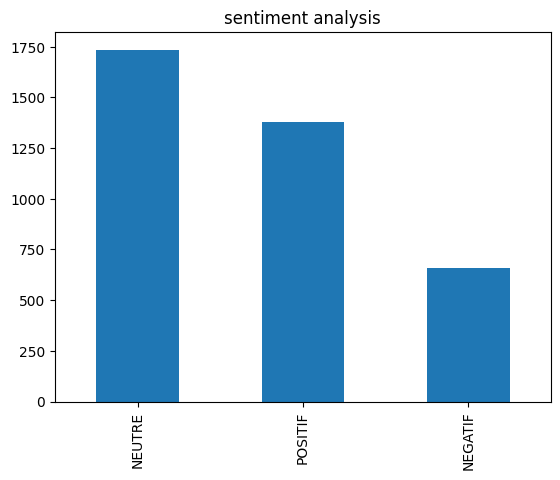

In [ ]:
def getPolarity(text):
    return compute_vader_scores(text).sentiment.polarity


df2.loc[df2.vader_comp>0,'sentiment_type']='POSITIF'
df2.loc[df2.vader_comp==0,'sentiment_type']='NEUTRE'
df2.loc[df2.vader_comp<0,'sentiment_type']='NEGATIF'

df2.sentiment_type.value_counts().plot(kind='bar',title="sentiment analysis")


In [ ]:
class0=[]
for i in range(len(df2)):
    if df2.loc[i,'vader_neg']>0:
        class0+=[0]
    elif df2.loc[i,'vader_pos']>0:
        class0+=[2]        
    else:
        class0+=[1]     


In [ ]:
df['class']=class0
df['class'].value_counts()

1    1727
2    1089
0     958
Name: class, dtype: int64

In [ ]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    Cette fonction tokenize pour avoir des integers et met de la même taille avec le pad
    '''
    # tokenization du texte
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # on transforme le texte en une séquence d'integers 
    X = tokenizer.texts_to_sequences(text)
    # on met la même longueur avec le padding des phrases
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Avant tokenisation et Padd  \n', df['cleantext2'][0])
X, tokenizer = tokenize_pad_sequences(df['cleantext2'])
print('Après tokénization \n', X[0])

Avant tokenisation et Padd  
 map bitcoin network http co 2lmxi3vfsv 
Après tokénization 
 [1415    3   78    2    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


<AxesSubplot: title={'center': 'Sentiment Analysis'}>

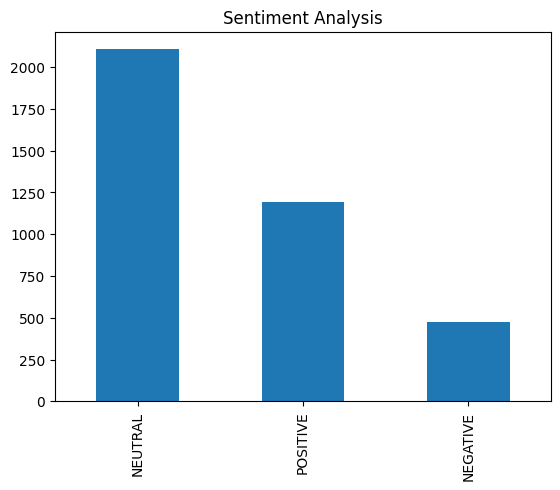

In [ ]:
from textblob import TextBlob

new_df4=df
new_df4['cleantext'] = df['cleantext2'].astype('str')
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

new_df4['Polarity'] = df['cleantext2'].apply(get_polarity)

new_df4['Sentiment_Type']=''
new_df4.loc[df.Polarity>0,'Sentiment_Type']='POSITIVE'
new_df4.loc[df.Polarity==0,'Sentiment_Type']='NEUTRAL'
new_df4.loc[df.Polarity<0,'Sentiment_Type']='NEGATIVE'

new_df4.Sentiment_Type.value_counts().plot(kind='bar',title="Sentiment Analysis")

# Analyse des tweets BTC des influenceurs crypto

In [1]:
import tweepy
import pandas as pd
from textblob import TextBlob
import warnings
warnings.filterwarnings("ignore")

# Configuration de l'API Twitter
consumer_key = "88dldRnuq6fLPQKkX8azrCd5p"
consumer_secret = "WTZDb3JRQUjZVRu6LhQNhIVzoQpZ2Cd2i6ePKnRATeQnBuNx6g"
access_token = "1435977329524752387-xa4DXdjkxgYNhbBJbdJZgySGC2YjRy"
access_token_secret = "CneEP3iDzDhiho3UDhAFjnPTvdUBcVAsluoH574urkINb"

# Connexion à l'API
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

# Recherche des tweets contenant le mot "Bitcoin"
# Liste des influenceurs
influencers = ['DocumentingBTC', 'MartyBent', 'lopp', 'nic__carter', 'Gladstein', 'BTC_Archive', 'natbrunell', '100trillionUSD', 'MessariCrypto', 'aantonop', 'VitalikButerin', 'SatoshiLite', 'NickSzabo4', 'rogerkver', 'aantonop', 'ErikVoorhees', 'brian_armstrong',' bgarlinghouse','cz_binance','bfmCrypto','crypto_futur','PowerHasheur','JulienROMAN13']

# Initialisation d'un DataFrame vide
df_tweets = pd.DataFrame(columns=['username', 'text', 'date'])

# Récupération des tweets de chaque influenceur
for influencer in influencers:
    tweets = api.user_timeline(screen_name=influencer, count=200)
    for tweet in tweets:
        df_tweets = df_tweets.append({'username': tweet.user.screen_name, 'text': tweet.text, 'date': tweet.created_at}, ignore_index=True)


# Nettoyage des tweets (suppression des mentions, des liens, etc.)
df_tweets['text'] = df_tweets['text'].str.replace('@\w+', '')
df_tweets['text'] = df_tweets['text'].str.replace('http\S+', '')

# Vérification du sentiment des tweets
df_tweets['polarity'] = df_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Sélection des tweets ayant un sentiment positif ou négatif
df_positive_tweets = df_tweets[df_tweets['polarity'] > 0]
df_negative_tweets = df_tweets[df_tweets['polarity'] < 0]

# Affichage des résultats
print("Il y a actuellement {} tweets positifs sur Bitcoin sur Twitter.".format(len(df_positive_tweets)))
print("Il y a actuellement {} tweets négatifs sur Bitcoin sur Twitter.".format(len(df_negative_tweets)))


if len(df_positive_tweets)>len(df_negative_tweets) :
    print("Les investisseurs sont confiants pour le Bitcoin actuellement !")
    
else :
    print("Les investisseurs sont prudents envers le Bitcoin actuellement !")


Il y a actuellement 1709 tweets positifs sur Bitcoin sur Twitter.
Il y a actuellement 588 tweets négatifs sur Bitcoin sur Twitter.
Les investisseurs sont confiants pour le Bitcoin actuellement !


# Fear and Gread

In [ ]:
import requests

url = "https://api.alternative.me/fng/"
response = requests.get(url)
data = response.json()

fng_index = int(data["data"][0]["value"])
if fng_index <= 25:
    print("Le marché est trop dans le rouge. Il est temps d'être prudent.")
elif fng_index >= 75:
    print("Le marché est trop dans le vert. Il est temps d'être vigilant.")
else:
    print("L'indice Fear and Greed actuel est de:", fng_index)
    
    print("L'indice est neutre")



L'indice Fear and Greed actuel est de: 56
L'indice est neutre


# Récupération et analyse du DXY

In [3]:
import requests
import json
import time

def check_dxy_trend():
    # API endpoint pour récupérer les données sur l'indice DX
    url = "https://www.alphavantage.co/query?function=DX&symbol=IBM&interval=daily&time_period=10&apikey=VMX2PEHMPL2NR42N"

    # Requête API pour récupérer les données sur l'indice DX
    response = requests.get(url)

    # Analyse de la réponse JSON
    data = json.loads(response.text)
    
    # Récupération des trois valeurs les plus récentes pour l'indice DX
    dx_values = [float(data["Technical Analysis: DX"][date]["DX"]) for date in list(data["Technical Analysis: DX"].keys())[:3]]

    # Vérification de la tendance en comparant les valeurs actuelles à celles de la veille
    trend = "Hausse" if all(dx_values[i] <= dx_values[i+1] for i in range(len(dx_values) - 1)) else "Baisse"
    print("La tendance actuelle de l'indice DX est :", trend)

while True:
    check_dxy_trend()
    time.sleep(24 * 60 * 60) # attendre 24 heures avant de relancer la vérification


    
######### j'obtiens que des tendances actuelles de baisse ????? Pourquoi ??? Normal ou pas ????




La tendance actuelle de l'indice DX est : Baisse


KeyboardInterrupt: 

# Analyse de la FED

In [4]:
import requests
import nltk
from selenium import webdriver
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

driver = webdriver.Chrome()
driver.implicitly_wait(10)
driver.get("https://www.federalreserve.gov/newsevents/pressreleases.htm")

# Cliquez sur la case à cocher pour la politique monétaire
monetary_policy_checkbox = WebDriverWait(driver, 10).until( 
    EC.element_to_be_clickable((By.XPATH,'//*[@id="content"]/div[2]/div/div[1]/form/div[4]/div[1]/label/input')))
monetary_policy_checkbox.click()

submit_checkbox = WebDriverWait(driver, 10).until( 
    EC.element_to_be_clickable((By.XPATH,'//*[@id="content"]/div[2]/div/div[1]/form/div[5]')))
submit_checkbox.click()

# Cliquez sur l'article le plus récent
recent_article = WebDriverWait(driver, 10).until(
    EC.element_to_be_clickable((By.XPATH, '//*[@id="article"]/div[1]/div[1]/div[2]/p[1]/span/a'))
)
recent_article.click()

element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "//*[@id='article']/div[3]")))
text = element.text

driver.quit()



sentiment_analyzer = SentimentIntensityAnalyzer()
sentences = nltk.sent_tokenize(text)
for sentence in sentences:
    sentiment = sentiment_analyzer.polarity_scores(sentence)['compound']
    if ("bitcoin" or "crypto" or "cryptomonnaie" or "crypto-actifs") in sentence.lower() and sentiment >= 0.05:
        print("Good news for bitcoin:", sentence)
        
    elif ("discount rate" or "credit rate" or "unemployment rate" or "inflation") in sentence.lower() and sentiment >= 0.05:
        print("Good news for bitcoin actually:", sentence)
        
    elif ("discount rate" or "credit rate" or "unemployment rate" or "inflation") in sentence.lower() and sentiment <= -0.05:
        print("Bad news for bitcoin actually:", sentence)
        
    elif ("bitcoin" or "crypto" or "cryptomonnaie" or "crypto-actifs") in sentence.lower() and sentiment <= -0.05:
        print("Bad news bitcoin actually:", sentence)
        
else :
    print("not news for btc actually")





not news for btc actually


# Analyse du site web pour connaitre les whales

In [19]:
import pandas
import time
from datetime import timezone
import datetime

btc_addresses = {
    '#3': '1P5ZEDWTKTFGxQjZphgWPQUpe554WKDfHQ',
    'Random': '14m3sd9HCCFJW4LymahJCKMabAxTK4DAqW',
    '#4':'1LQoWist8KkaUXSPKZHNvEyfrEkPHzSsCd',
    '#5':'bc1qazcm763858nkj2dj986etajv6wquslv8uxwczt',
    '#6':'37XuVSEpWW4trkfmvWzegTHQt7BdktSKUs',
    '#7':'1FeexV6bAHb8ybZjqQMjJrcCrHGW9sb6uF',
    '#8':'bc1qa5wkgaew2dkv56kfvj49j0av5nml45x9ek9hz6',
    'binance reserve':'3LYJfcfHPXYJreMsASk2jkn69LWEYKzexb',
    '#10':'bc1qd4ysezhmypwty5dnw7c8nqy5h5nxg0xqsvaefd0qn5kq32vwnwqqgv4rzr',
    '#11':'1LdRcdxfbSnmCYYNdeYpUnztiYzVfBEQeC',
    '#12':'1AC4fMwgY8j9onSbXEWeH6Zan8QGMSdmtA'
    }

t_time = {}
amount = {}

for key in btc_addresses:
    t_time[key] = 0
    amount[key] = 0

check_again = True

while True:
    time.sleep(1)
    while check_again:
        for whale in btc_addresses:
            transactions_url = 'https://blockchain.info/rawaddr/' + btc_addresses[whale]
            df               = pandas.read_json(transactions_url)
            transactions     = df['txs']
            last_time        = transactions[0]['time']
            last_amount      = transactions[0]['result']
            
            if last_time != t_time[whale]:
                t_time[whale] = last_time
                amount[whale] = last_amount
                
                if int(last_amount) > 0:
                    direction = "accumule"
                elif int(last_amount) < 0:
                    direction = "vend"

                btc_amount = int((float(abs(last_amount))/100000000))
                print(f'{whale} is {direction} {btc_amount} BTC')
                messages=[f'Whale Alert: {whale} is {direction} {btc_amount} BTC']
                print(messages)

            time.sleep(15)

        check_again = False

    now      = datetime.datetime.now(timezone.utc)
    midnight = now.replace(hour=0, minute=0, second=0, microsecond=0)
    minutes  = ((now - midnight).seconds) // 60

    if (minutes % 60) == 0:
        messages=['Whale watcher checking in.']
        print(messages)
        time.sleep(60)
        check_again = True



#3 is accumulating 0 BTC
['Whale Alert: #3 is accumulating 0 BTC']
Random is dumping 5 BTC
['Whale Alert: Random is dumping 5 BTC']
#4 is accumulating 0 BTC
['Whale Alert: #4 is accumulating 0 BTC']
#5 is accumulating 0 BTC
['Whale Alert: #5 is accumulating 0 BTC']
#6 is accumulating 0 BTC
['Whale Alert: #6 is accumulating 0 BTC']
#7 is accumulating 0 BTC
['Whale Alert: #7 is accumulating 0 BTC']
#8 is accumulating 0 BTC
['Whale Alert: #8 is accumulating 0 BTC']
binance reserve is accumulating 68200 BTC
['Whale Alert: binance reserve is accumulating 68200 BTC']
#10 is dumping 0 BTC
['Whale Alert: #10 is dumping 0 BTC']
#11 is accumulating 0 BTC
['Whale Alert: #11 is accumulating 0 BTC']
#12 is accumulating 0 BTC
['Whale Alert: #12 is accumulating 0 BTC']


KeyboardInterrupt: 

# Analyse des tweets de Whale Alert 

In [2]:
import tweepy
import time

# Configuration de l'authentification Twitter
auth = tweepy.OAuthHandler("88dldRnuq6fLPQKkX8azrCd5p", "WTZDb3JRQUjZVRu6LhQNhIVzoQpZ2Cd2i6ePKnRATeQnBuNx6g")
auth.set_access_token("1435977329524752387-xa4DXdjkxgYNhbBJbdJZgySGC2YjRy", "CneEP3iDzDhiho3UDhAFjnPTvdUBcVAsluoH574urkINb")

# Utilisation de l'authentification pour accéder à l'API Twitter
api = tweepy.API(auth)

# Récupération des tweets de "whale_alert" contenant le #BTC ou #WBTC
tweets = api.user_timeline(screen_name="whale_alert", count=200)
for tweet in tweets:
    if "#BTC" in tweet.text or "#WBTC" in tweet.text:
        # Analyse du tweet pour déterminer s'il est dangereux ou normal
        num_emojis = tweet.text.count("🚨")
        if num_emojis == 2 or num_emojis == 3:
            danger_level = "DANGEREUX"
        elif num_emojis > 3 :
            danger_level = "TRES DANGEREUX, FLUCTUATION DU BTC A PREVOIR "
        else:
            danger_level = "NORMAL"
            
            
        text_without_links = tweet.text
        for url in tweet.entities.get('urls'):
            text_without_links = text_without_links.replace(url['url'], '')

            
            
        # Affichage du tweet en entier avec l'indication de son niveau de danger
        print(f"Tweet suivant, posté le {tweet.created_at},avec {num_emojis} emojis 🚨:\n- {danger_level}\n- {text_without_links}\n------------------------\n")

# Pause pour ne pas dépasser les limites d'accès à l'API Twitter
time.sleep(60)


Tweet suivant, posté le 2023-02-14 20:57:23+00:00,avec 2 emojis 🚨:
- DANGEREUX
- 🚨 🚨  1,286 #BTC (28,616,212 USD) transferred from #Coinbase to unknown wallet


------------------------

Tweet suivant, posté le 2023-02-11 20:44:38+00:00,avec 2 emojis 🚨:
- DANGEREUX
- 🚨 🚨  2,000 #BTC (43,375,874 USD) transferred from unknown wallet to #Coinbase


------------------------

Tweet suivant, posté le 2023-02-11 01:58:48+00:00,avec 1 emojis 🚨:
- NORMAL
- 🚨  1,001 #BTC (21,665,260 USD) transferred from unknown wallet to #Coinbase


------------------------



In [29]:
from pytrends.request import TrendReq

pytrend = TrendReq()
# construire une liste de mots clés liés au Bitcoin
keywords = ["bitcoin", "BTC", "crypto-monnaie", "cryptographie", "blockchain", "mineur de bitcoin", "portefeuille bitcoin","Bitcoin","crypto-monnaie", "blockchain", "mining", "wallet", "échange", "transaction", "décentralisation", "sécurité", "Satoshi Nakamoto", "halving", "ASIC", "nœud", "vérification", "adresse", "clé privée", "clé publique", "preuve de travail", "preuve d'enjeu", "investissement", "volatilité", "marché", "réglementation", "adoption", "frais de transaction", "altcoin", "hard fork", "soft fork", "Lightning Network", "confidentialité", "escrow", "anonymat", "smart contract", "FOMO", "FUD", "hodl", "bull run", "bear market", "whale", "parrainage", "plateforme d'échange", "hashrate", "protocole", "white paper", "minage en nuage", "cold storage", "hot wallet", "portefeuille matériel", "portefeuille logiciel", "identité", "signature numérique", "livret blanc", "consensus", "mécanisme de consensus", "réseau peer-to-peer", "infrastructure", "crypto-économie", "chiffrage", "clé secrète", "portefeuille mobile", "portefeuille papier", "sécurité multi-signatures", "stockage à froid", "stockage à chaud", "forks", "contrats intelligents", "mythes", "FOMO", "to the moon", "gouvernance", "chaînes latérales", "stabilité", "transactions confidentielles", "identité numérique", "Jeton", "ICO", "DEX", "Bitcoin maximalisme", "stratégie d'investissement", "portefeuille de diversification", "moyen d'échange", "réserve de valeur", "finance décentralisée", "échange décentralisé", "échange centralisé", "fragmentation de transactions", "inflation", "ordinateur quantique", "bifurcation de la chaîne", "fork dur", "fork doux", "forks intentionnels", "forks non intentionnels", "hard fork contentieux", "protocole de consensus", "preuve d'enjeu", "preuve de participation", "bloc", "récompense de bloc", "adresse bitcoin", "hachage","ETH","AVA","etherium"]


related_queries= pytrend.trending_searches()

print(related_queries)

data=pd.DataFrame(related_queries)

# Vérifier si au moins un mot-clé est présent dans les colonnes de la dataframe data
if any(keyword.lower() in data.columns for keyword in keywords):
    print("Le Bitcoin est en vogue actuellement !")
else:
    print("Le Bitcoin n'est pas en vogue actuellement.")



                                   0
0                      Ryan Seacrest
1                            Nuggets
2                       Raquel Welch
3                Arsenal vs Man City
4                Dortmund vs Chelsea
5              Ohio train derailment
6                      Europa League
7                   El Paso shooting
8   Winnie-the-Pooh: Blood and Honey
9                             NASCAR
10                     Chiefs parade
11                     Mikal Bridges
12                   Buffalo shooter
13                            Bruins
14                      Lana Del Rey
15                         Lady Gaga
16                      Marc Anthony
17                             Bulls
18                     Jerry Jarrett
19                        Marc Maron
Le Bitcoin n'est pas en vogue actuellement.


In [1]:
from pytrends.request import TrendReq

# Initialiser l'objet TrendReq avec vos informations de connexion Google
pytrends = TrendReq(hl='fr-FR', tz=0)

# Définir les termes de recherche et la période
kw_list = ["Bitcoin","blockchain","crypto-monnaie","transaction", "décentralisation"]
pytrends.build_payload(kw_list, timeframe='today 1-m')

# Récupérer les données de tendance
bitcoin_trends = pytrends.interest_over_time()
# Calculer la moyenne des tendances pour la période sélectionnée
avg_trend = bitcoin_trends.mean()[0]

# Afficher la moyenne des tendances
if avg_trend > 50:
    print("Le Bitcoin est en vogue avec une moyenne de tendance de", avg_trend)
else:
    print("Le Bitcoin n'est pas en vogue avec une moyenne de tendance de", avg_trend)


Le Bitcoin est en vogue avec une moyenne de tendance de 75.08
